

A better design would be object-oriented with a parent class accounting for the case with no previous data, and a child class handling the case where there is previous data that needs to be updated.

## Load useful libraries

In [1]:
import json
import requests
import datetime
import time
import pytz
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt

## User settings

Using papermill, we can change this with command line arguments:

In [2]:
# This cell is tagged `parameters`

config_file = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forex/data/DEVELOPMENT.json'
count = 5000 
granularity = 'H1'
now = True
instruments = 'EUR_USD,USD_CAD,USD_JPY,USD_CHF,AUD_USD,GBP_USD,NZD_USD'
price_types = 'BAM'
error_retry_interval = 5

## Fixed settings and initialization

In [3]:
timezone_to_use = 'America/Toronto'   # Don't change this!
end_date = None

output_file_sans_extension = 'output/' + granularity
start_time_no_previous = datetime.datetime(2010, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc).timestamp()

## Convert the given instrument names to a list

In [4]:
instrument_list = instruments.split(',')

## Quick QA of papermill's argument fill

In [5]:
print(count)
print(granularity)

5000
H1


## See if we already have prior data

In [6]:
have_prior_data = True
try:
    df = pd.read_parquet(output_file_sans_extension + '.parquet')
    df = df[df['complete']].copy()
    df.head()
except:
    have_prior_data = False

## Define a function to pull min/max times per instrument

In [7]:
def get_min_max_times(df):

    df_agg_min = df[['instrument', 'time']].groupby(['instrument'])['time'].agg('min').reset_index()
    df_agg_min.index = df_agg_min['instrument']
    df_agg_min.drop(columns = ['instrument'], inplace = True)
    dict_instrument_to_min_time = df_agg_min.to_dict(orient = 'index')
    pp.pprint(dict_instrument_to_min_time)

    print()

    df_agg_max = df[['instrument', 'time']].groupby(['instrument'])['time'].agg('max').reset_index()
    df_agg_max.index = df_agg_max['instrument']
    df_agg_max.drop(columns = ['instrument'], inplace = True)
    dict_instrument_to_max_time = df_agg_max.to_dict(orient = 'index')
    pp.pprint(dict_instrument_to_max_time)

    print()

    for instrument in dict_instrument_to_min_time.keys():
        print(instrument + ': ', datetime.datetime.fromtimestamp(dict_instrument_to_min_time[instrument]['time']))
        
    print()
    for instrument in dict_instrument_to_min_time.keys():
        print(instrument + ': ', datetime.datetime.fromtimestamp(dict_instrument_to_max_time[instrument]['time']))

    return dict_instrument_to_min_time, dict_instrument_to_max_time

## See where we are at:

In [8]:
if have_prior_data:
    dict_instrument_to_min_time, dict_instrument_to_max_time = get_min_max_times(df)

{'AUD_USD': {'time': 1020715200},
 'EUR_USD': {'time': 1020715200},
 'GBP_USD': {'time': 1020715200},
 'NZD_USD': {'time': 1032811200},
 'USD_CAD': {'time': 1020801600},
 'USD_CHF': {'time': 1020715200},
 'USD_JPY': {'time': 1020715200}}

{'AUD_USD': {'time': 1744977600},
 'EUR_USD': {'time': 1744977600},
 'GBP_USD': {'time': 1744977600},
 'NZD_USD': {'time': 1744977600},
 'USD_CAD': {'time': 1744977600},
 'USD_CHF': {'time': 1744977600},
 'USD_JPY': {'time': 1744977600}}

AUD_USD:  2002-05-06 13:00:00
EUR_USD:  2002-05-06 13:00:00
GBP_USD:  2002-05-06 13:00:00
NZD_USD:  2002-09-23 13:00:00
USD_CAD:  2002-05-07 13:00:00
USD_CHF:  2002-05-06 13:00:00
USD_JPY:  2002-05-06 13:00:00

AUD_USD:  2025-04-18 05:00:00
EUR_USD:  2025-04-18 05:00:00
GBP_USD:  2025-04-18 05:00:00
NZD_USD:  2025-04-18 05:00:00
USD_CAD:  2025-04-18 05:00:00
USD_CHF:  2025-04-18 05:00:00
USD_JPY:  2025-04-18 05:00:00


## Specify the timezone

Not sure this is needed...

In [9]:
timezone = pytz.timezone(timezone_to_use)

## Specify the end time for the loop

In [10]:
end_date_original = int(time.mktime(datetime.datetime.now().timetuple()))
end_date = end_date_original

## Load the configuration file

In [11]:
with open(config_file) as f:
    config = json.load(f)

## Define a function to obtain the Oanda headers

Later:  Move this into a library module or something...

In [12]:
def get_oanda_headers():
    headers = {
        'Content-Type' : 'application/json',
        'Authorization' : 'Bearer ' + config['token'],
        'Accept-Datetime-Format' : config['oanda_date_time_format'],
    }
    return headers

## Get the Oanda headers

In [13]:
headers = get_oanda_headers()

## Define a function send a request to Oanda for historical candlestick values

In [14]:
def get_instrument_candlesticks(instrument, count, price_types, granularity, end_date):
    url = config['server'] + '/v3/instruments/' + instrument + '/candles?count=' + str(count) + '&price=' + price_types + '&granularity=' + granularity + '&to=' + str(end_date)

    worked = False
    while not worked:
        try:
            r = requests.get(url, headers=headers)
            worked = True
        except:
            time.sleep(error_retry_interval)
        
    rj = r.json()
    return rj

## Process the candlestick data

Here we add additional features.

This alters the dictionary in place; not my favorite design idiom:

In [15]:
def deal_with_candlestick_format_and_time(candle):
    candle['time'] = int(float(candle['time']))
    time_dt = datetime.datetime.fromtimestamp(candle['time'], tz = timezone)
    candle['time_iso'] = time_dt.isoformat()
    candle['weekday'] = time_dt.weekday()
    candle['hour'] = time_dt.hour

    #
    # deal with prices that are currently string values but need to be float
    #
    # and reorganize them
    #
    for price_type in ['bid', 'mid', 'ask']:
        for candlestick_component in candle[price_type].keys():
            candle[price_type + '_' + candlestick_component] = float(candle[price_type][candlestick_component])
        candle[price_type + '_return'] = candle[price_type + '_c'] - candle[price_type + '_o']
        candle[price_type + '_volatility'] = candle[price_type + '_h'] - candle[price_type + '_l']
            
    for price_type in ['bid', 'mid', 'ask']:
        del(candle[price_type])
            
    return None

## Iterate through the instruments while pulling Oanda data for each instrument

In [16]:
if True:  # Might make this a function later... setting up proper indentation to do so:
    
    insert_many_list = []
    for instrument in instrument_list:

        if have_prior_data:
            try:
                start_time = dict_instrument_to_max_time[instrument]['time']
            except:
                start_time = start_time_no_previous
        else:
            start_time = start_time_no_previous

        
        # initialize per instrument
        finished = False
        end_date = end_date_original

        # loop through the timestamp ranges for each set of n=count values
        while not finished:

            # retrieve the instrument candlesticks from the Oanda server
            rj = get_instrument_candlesticks(instrument, count, price_types, granularity, end_date)        


            candlesticks = rj['candles']
            
            # deal with timestamps and time-related content
            date_list = []
            for candle in candlesticks:
                deal_with_candlestick_format_and_time(candle)
                date_list.append(candle['time'])
                
            rj['timestamp_int_min'] = min(date_list)
            rj['timestamp_int_max'] = max(date_list)

            insert_many_list.append(rj)

            # Are we done with the current instrument?
            if len(date_list) < count:
                finished = True

            if min(date_list) < start_time:
                finished = True
            
            # prepare for the next iteration
            end_date = rj['timestamp_int_min'] - 0.1

## Finalize each record's data (annotation)

In [17]:
if True:
    candlestick_dict_list = []
    for item in insert_many_list:
        instrument = item['instrument']
        granularity = item['granularity']
        candles_list = item['candles']
        for candle in candles_list:

            candle['instrument'] = instrument
            candle['granularity'] = granularity

            # we check this again later in the final assembly
            if candle['complete']:
                candlestick_dict_list.append(candle)

## Create a new dataframe using the newly obtained data

In [18]:
df_new = pd.DataFrame(candlestick_dict_list)
df_new = df_new[df_new['complete']].copy()

df_new.head()

,complete,volume,time,time_iso,weekday,hour,bid_o,bid_h,bid_l,bid_c,...,mid_return,mid_volatility,ask_o,ask_h,ask_l,ask_c,ask_return,ask_volatility,instrument,granularity
0,True,4910,1719846000,2024-07-01T11:00:00-04:00,0,11,1.07295,1.07298,1.07189,1.07262,...,-0.00033,0.00109,1.07309,1.07312,1.07203,1.07276,-0.00033,0.00109,EUR_USD,H1
1,True,2600,1719849600,2024-07-01T12:00:00-04:00,0,12,1.07263,1.07324,1.07235,1.07307,...,0.00045,0.00090,1.07278,1.07340,1.07250,1.07323,0.00045,0.00090,EUR_USD,H1
2,True,2099,1719853200,2024-07-01T13:00:00-04:00,0,13,1.07308,1.07328,1.07272,1.07286,...,-0.00022,0.00055,1.07323,1.07343,1.07288,1.07301,-0.00022,0.00055,EUR_USD,H1
3,True,2151,1719856800,2024-07-01T14:00:00-04:00,0,14,1.07287,1.07295,1.07234,1.07289,...,0.00001,0.00060,1.07303,1.07309,1.07250,1.07303,0.00000,0.00059,EUR_USD,H1
4,True,2276,1719860400,2024-07-01T15:00:00-04:00,0,15,1.07289,1.07386,1.07287,1.07376,...,0.00088,0.00099,1.07304,1.07401,1.07303,1.07392,0.00088,0.00098,EUR_USD,H1


## Calculate the newly pulled min and max times

This only includes newly pulled data, not any previous data we may have loaded above:

In [19]:
dict_instrument_to_new_min_time, dict_instrument_to_new_max_time = get_min_max_times(df_new)

{'AUD_USD': {'time': 1719846000},
 'EUR_USD': {'time': 1719846000},
 'GBP_USD': {'time': 1719846000},
 'NZD_USD': {'time': 1719846000},
 'USD_CAD': {'time': 1719846000},
 'USD_CHF': {'time': 1719846000},
 'USD_JPY': {'time': 1719846000}}

{'AUD_USD': {'time': 1745269200},
 'EUR_USD': {'time': 1745269200},
 'GBP_USD': {'time': 1745269200},
 'NZD_USD': {'time': 1745269200},
 'USD_CAD': {'time': 1745269200},
 'USD_CHF': {'time': 1745269200},
 'USD_JPY': {'time': 1745269200}}

AUD_USD:  2024-07-01 08:00:00
EUR_USD:  2024-07-01 08:00:00
GBP_USD:  2024-07-01 08:00:00
NZD_USD:  2024-07-01 08:00:00
USD_CAD:  2024-07-01 08:00:00
USD_CHF:  2024-07-01 08:00:00
USD_JPY:  2024-07-01 08:00:00

AUD_USD:  2025-04-21 14:00:00
EUR_USD:  2025-04-21 14:00:00
GBP_USD:  2025-04-21 14:00:00
NZD_USD:  2025-04-21 14:00:00
USD_CAD:  2025-04-21 14:00:00
USD_CHF:  2025-04-21 14:00:00
USD_JPY:  2025-04-21 14:00:00


## QA #2

In [20]:
if have_prior_data:
    print(len(df.index))

print(len(df_new.index))

907007
34993


In [21]:
if have_prior_data:
    df.head()

In [22]:
df_new.head()

,complete,volume,time,time_iso,weekday,hour,bid_o,bid_h,bid_l,bid_c,...,mid_return,mid_volatility,ask_o,ask_h,ask_l,ask_c,ask_return,ask_volatility,instrument,granularity
0,True,4910,1719846000,2024-07-01T11:00:00-04:00,0,11,1.07295,1.07298,1.07189,1.07262,...,-0.00033,0.00109,1.07309,1.07312,1.07203,1.07276,-0.00033,0.00109,EUR_USD,H1
1,True,2600,1719849600,2024-07-01T12:00:00-04:00,0,12,1.07263,1.07324,1.07235,1.07307,...,0.00045,0.00090,1.07278,1.07340,1.07250,1.07323,0.00045,0.00090,EUR_USD,H1
2,True,2099,1719853200,2024-07-01T13:00:00-04:00,0,13,1.07308,1.07328,1.07272,1.07286,...,-0.00022,0.00055,1.07323,1.07343,1.07288,1.07301,-0.00022,0.00055,EUR_USD,H1
3,True,2151,1719856800,2024-07-01T14:00:00-04:00,0,14,1.07287,1.07295,1.07234,1.07289,...,0.00001,0.00060,1.07303,1.07309,1.07250,1.07303,0.00000,0.00059,EUR_USD,H1
4,True,2276,1719860400,2024-07-01T15:00:00-04:00,0,15,1.07289,1.07386,1.07287,1.07376,...,0.00088,0.00099,1.07304,1.07401,1.07303,1.07392,0.00088,0.00098,EUR_USD,H1


## Calculate the complete dataframe

Result should combine previously and newly obtained results, whilst removing duplicates:

In [23]:
if have_prior_data:
    df_full = pd.concat([df, df_new]).sort_values(['time', 'instrument']).drop_duplicates()
else:
    df_full = df_new.sort_values(['time', 'instrument']).drop_duplicates().copy()

count = 0
for instrument in instrument_list:
    df_temp = df_full[df_full['instrument'] == instrument]
    count += len(df_temp['time'].unique())

## More QA

In [24]:
print(len(df_full.index) == count)

True


In [25]:
if have_prior_data:
    print(len(df.index) + len(df_new.index))
    print(len(pd.concat([df, df_new]).sort_values(['time', 'instrument']).index))
    
print(len(df_full.index))

942000
942000
907238


## Plot-based QA

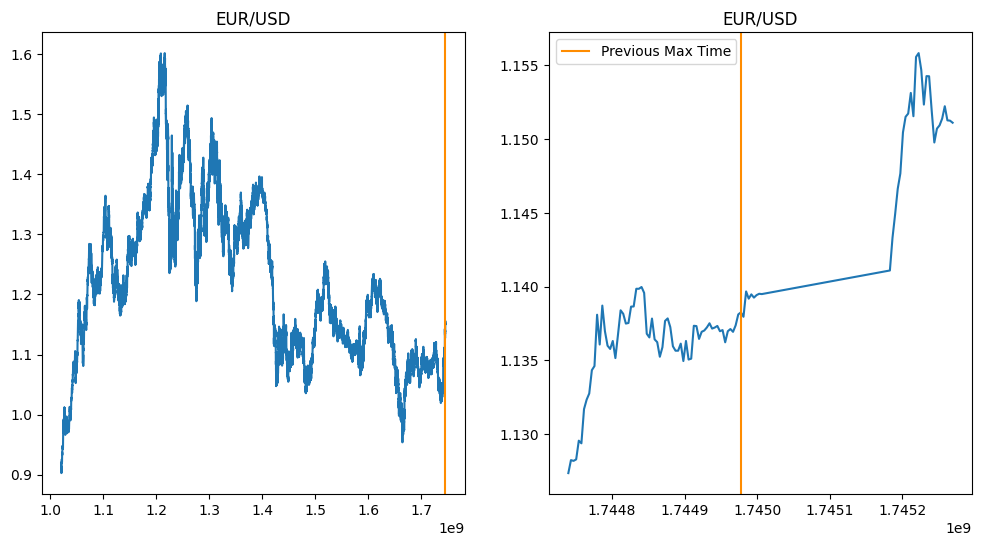

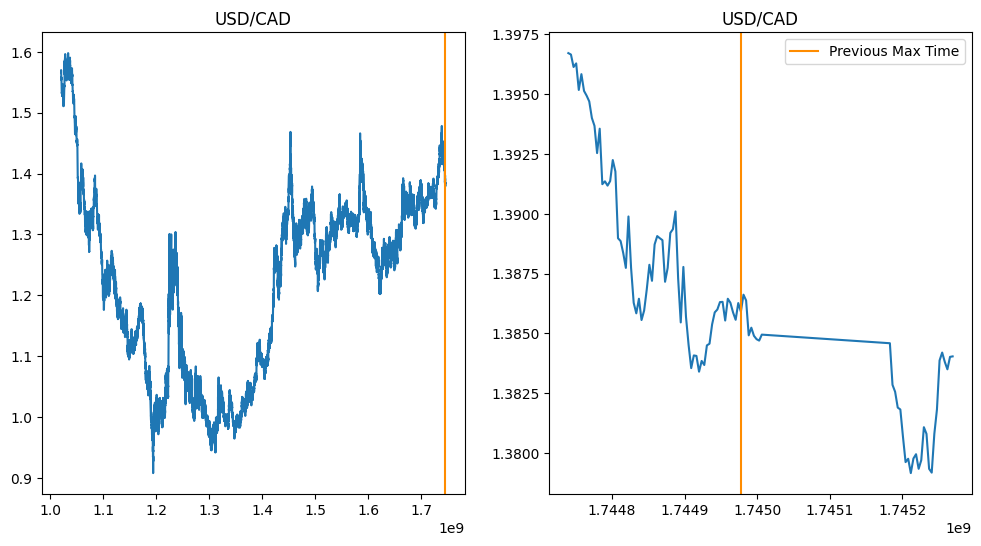

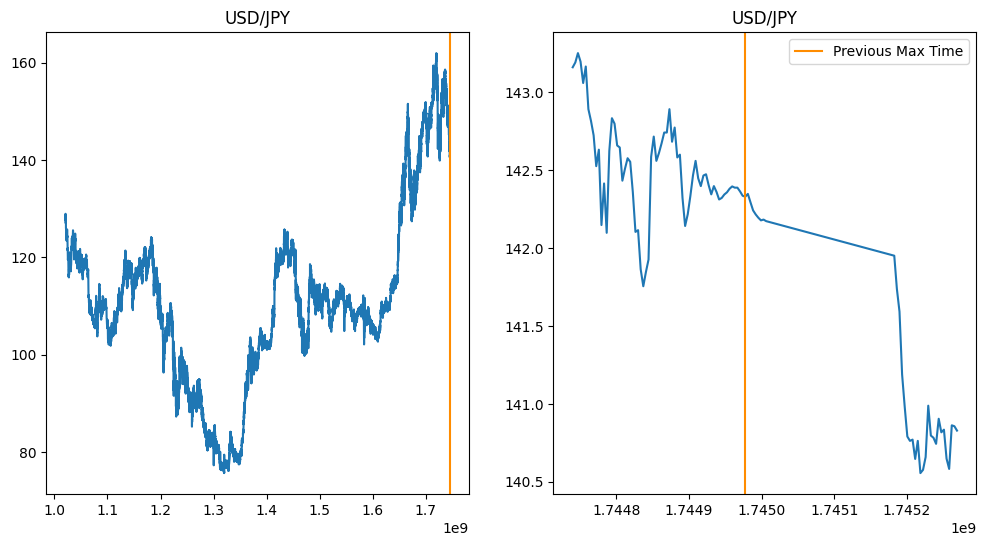

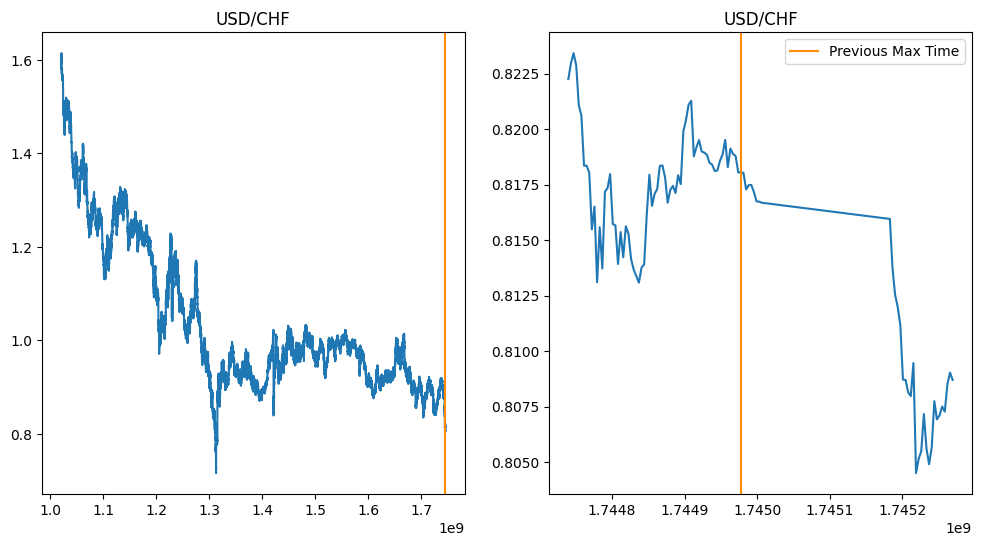

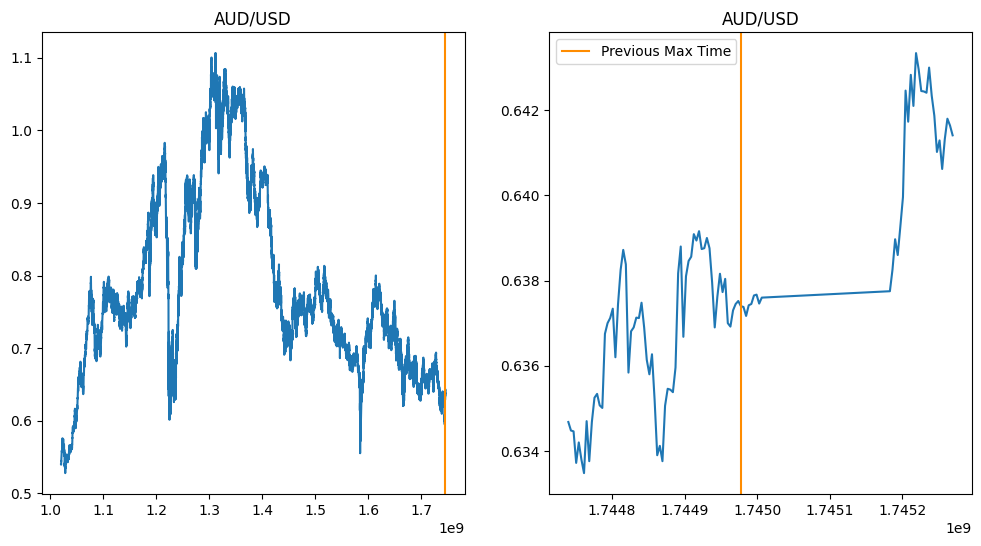

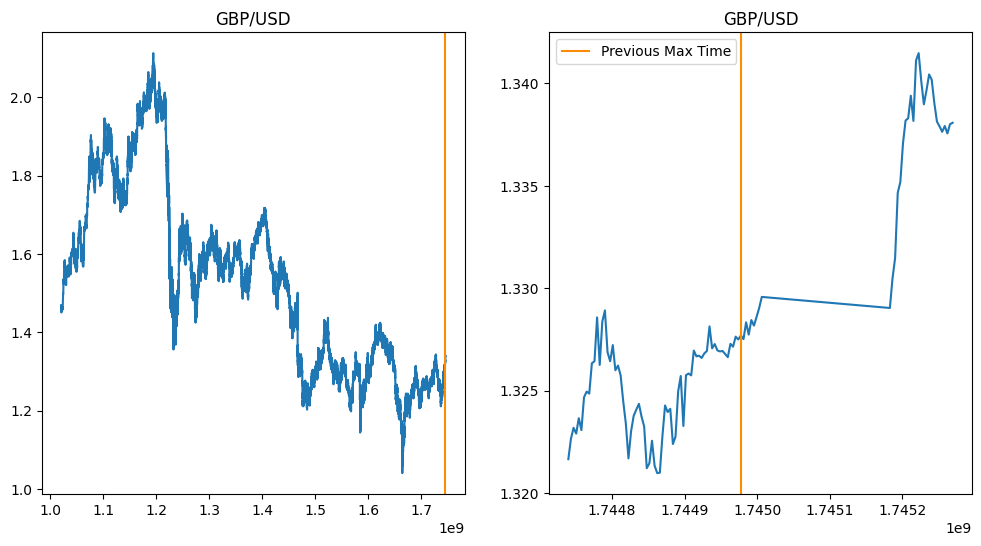

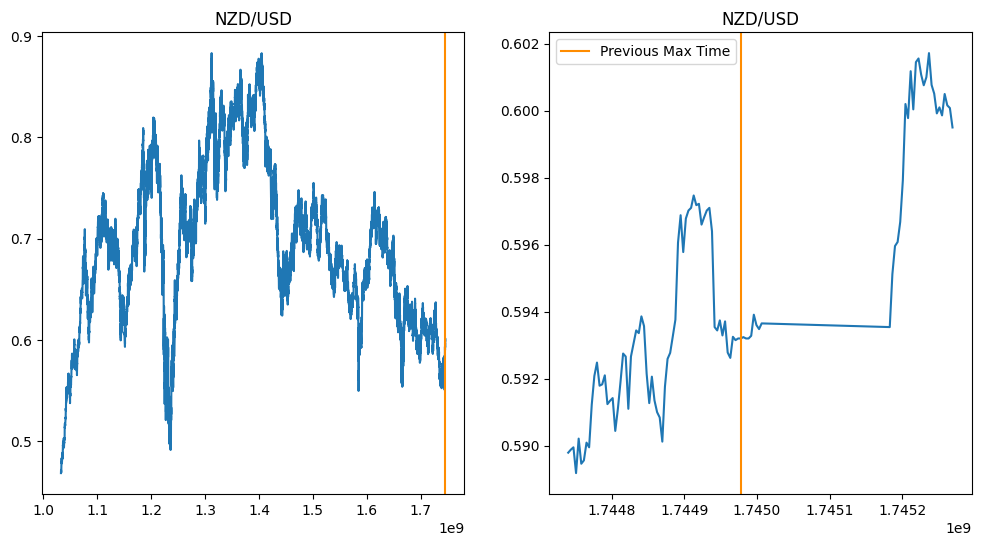

In [26]:
column_to_plot = 'mid_c'
for instrument in instrument_list:

    n = 100  # Crude, but this is a QA
    
    df_to_plot = df_full[df_full['instrument'] == instrument].sort_values(by = ['time'])

    values_x = df_to_plot['time']
    values_y = df_to_plot[column_to_plot]
    
    plt.figure(figsize = [12, 6])

    if have_prior_data:
        plt.subplot(1, 2, 1)
        
    plt.plot(values_x, values_y)

    if have_prior_data:
        plt.axvline(dict_instrument_to_max_time[instrument]['time'], color = 'darkorange')
    
    plt.title(instrument.replace('_', '/'))

    if have_prior_data:
        plt.subplot(1, 2, 2)
        plt.plot(values_x[(-1 * n):], values_y[(-1 * n):])
    
        if have_prior_data:
            plt.axvline(dict_instrument_to_max_time[instrument]['time'], color = 'darkorange', label = 'Previous Max Time')
        
        plt.title(instrument.replace('_', '/'))
        plt.legend()
    
    plt.show()
    plt.close()    